<a href="https://colab.research.google.com/github/jyesudian/AnoNetworkData/blob/main/Luflow_LightGBM_CatBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# prompt: Need help in deriving PCA for a dataset. I need sample code. Also, I would like to use the dataset LuFlow which is available in my Google Drive. I think I need to do data engineering on the dataset. Can you give the step by step example and the code accordingly?
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

import seaborn as sns


In [3]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 27.9 MB/s eta 0:00:00


In [4]:
import lightgbm as lgb
import catboost as cb

In [ ]:
### To check whether GPU is used.
gpu_available = tf.config.list_physical_devices('GPU')

if gpu_available:
    print("GPU is available and being used.")
    print("GPU Details:", gpu_available)
else:
    print("GPU is not available. Using CPU.")

GPU is available and being used.
GPU Details: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score,confusion_matrix,classification_report,roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

In [6]:
from google.colab import drive
drive.mount('/content/drive')
# Define the file path to your dataset in Google Drive
#file_path = '/content/drive/MyDrive/LuFlow.csv'
#file_path = '/content/drive/MyDrive/VIT/Dataset/LuFlow2021/luflow.csv'


Mounted at /content/drive


In [7]:
# Define the file paths in Google Drive
saved_entropy_file_path = '/content/drive/MyDrive/VIT/Dataset/LuFlow2021/WithEntropies.csv'
saved_noentropy_file_path = '/content/drive/MyDrive/VIT/Dataset/LuFlow2021/WithOutEntropies.csv'

# Read the CSV files back into pandas DataFrames
df_with_entropies_loaded = pd.read_csv(saved_entropy_file_path)
df_without_entropies_loaded = pd.read_csv(saved_noentropy_file_path)

# Optional: Display the first few rows and shape to verify they are loaded correctly
print("First 5 rows of df_with_entropies_loaded:")
print(df_with_entropies_loaded.head())
print("\nShape of df_with_entropies_loaded:")
print(df_with_entropies_loaded.shape)

First 5 rows of df_with_entropies_loaded:
   avg_ipt  bytes_in  bytes_out  dest_ip  dest_port  entropy  num_pkts_out  \
0      0.0         0          0      786    31306.0      0.0             1   
1      0.0         0          0      786    24298.0      0.0             1   
2      0.0         0          0      786    31789.0      0.0             1   
3      0.0         0          0      786    29409.0      0.0             1   
4      0.0         0          0      786    60965.0      0.0             1   

   num_pkts_in  proto  src_ip  src_port  total_entropy    label  duration  \
0            0      6     786   47613.0            0.0  outlier       0.0   
1            0      6     786   47613.0            0.0  outlier       0.0   
2            0      6     786   47613.0            0.0  outlier       0.0   
3            0      6     786   47613.0            0.0  outlier       0.0   
4            0      6     786   47613.0            0.0  outlier       0.0   

                time_start

**Now Proceed With Entropies as the Entropy calculation is done by the Luflow dataset providers itself.**

In [8]:
def dropInfNull(df):
    print (df.shape)

    # replace infinity value as null value
    df = df.replace(["Infinity", "infinity"], np.inf)
    df = df.replace([np.inf, -np.inf], np.nan)

    # drop all null values
    df.dropna(inplace=True)

    print (df.shape)

    return df

In [9]:
%%time
network_data_d1 = dropInfNull(df_with_entropies_loaded)

(1068376, 19)
(964168, 19)
CPU times: user 1.12 s, sys: 22.3 ms, total: 1.14 s
Wall time: 1.14 s


In [10]:
#Get the unique labels
unique_labels = network_data_d1['label'].unique()

#Get the counts of each unique label
label_counts = network_data_d1['label'].value_counts()

#Print the results

print("Unique Labels:")
print(unique_labels)

print("\nCounts of Each Label:")
print(label_counts)

Unique Labels:
['outlier' 'benign' 'malicious']

Counts of Each Label:
label
benign       517209
outlier      368843
malicious     78116
Name: count, dtype: int64


In an anomaly detection context, "outlier" often signifies something unusual or potentially suspicious, even if it doesn't fit a known malicious signature. Grouping "malicious" and "outlier" together allows your model to learn to distinguish between "normal" traffic and any form of unusual or potentially harmful traffic captured in these two categories.

In [11]:
network_data_d1['binary_label'] = network_data_d1['label'].apply(lambda x: 0 if x == 'benign' else 1)

## After converting the binary_label, we can drop the label column from the dataset
del_columns = ['label']

network_data_d1 = network_data_d1.drop(columns=del_columns, errors='ignore')

In [12]:
#Get the counts of each unique label
label_counts = network_data_d1['binary_label'].value_counts()
print("\nCounts of Each Label:")
print(label_counts)


Counts of Each Label:
binary_label
0    517209
1    446959
Name: count, dtype: int64


In [13]:
df_balanced = network_data_d1

**Understanding the Data Type of the Dataset**

In [14]:
# Access the dtypes attribute
feature_data_types = df_balanced.dtypes

# Print the data types
print("Data Types of Features:")
print(feature_data_types)

Data Types of Features:
avg_ipt                 float64
bytes_in                  int64
bytes_out                 int64
dest_ip                   int64
dest_port               float64
entropy                 float64
num_pkts_out              int64
num_pkts_in               int64
proto                     int64
src_ip                    int64
src_port                float64
total_entropy           float64
duration                float64
time_start_dt            object
time_end_dt              object
start_hour_of_day         int64
start_day_of_week         int64
start_minute_of_hour      int64
binary_label              int64
dtype: object


**Raw datetime64[ns] objects cannot be directly used as input features for most standard ML/ANN algorithms. These algorithms expect numerical inputs. As the temporal values such as start_hour_of_day, start_day_of_week and start_minute_of_hour is captured with in dataset, those date time format columns can be removed.**

In [15]:
df_balanced = df_balanced.drop(columns=['time_start_dt', 'time_end_dt'])

**Drop Constant Column**

In [16]:
%%time
# drop the constant columns (which varience is 0)
variances = df_balanced.var(numeric_only=True)
constant_columns = variances[variances == 0].index
df_balanced = df_balanced.drop(constant_columns, axis=1)

print(constant_columns)
print (df_balanced.shape)

Index(['dest_ip', 'src_ip'], dtype='object')
(964168, 15)
CPU times: user 47 ms, sys: 18.3 ms, total: 65.2 ms
Wall time: 64 ms


**Drop Duplicate Column**

In [17]:
duplicates = set()
for i in range(0, len(df_balanced.columns)):
    col1 = df_balanced.columns[i]
    for j in range(i+1, len(df_balanced.columns)):
        col2 = df_balanced.columns[j]
        if(df_balanced[col1].equals(df_balanced[col2])):
            duplicates.add(col2)

print (duplicates)
df_balanced.drop(duplicates, axis=1, inplace=True)
print (df_balanced.shape)

set()
(964168, 15)


**Drop Columns based on correlation**

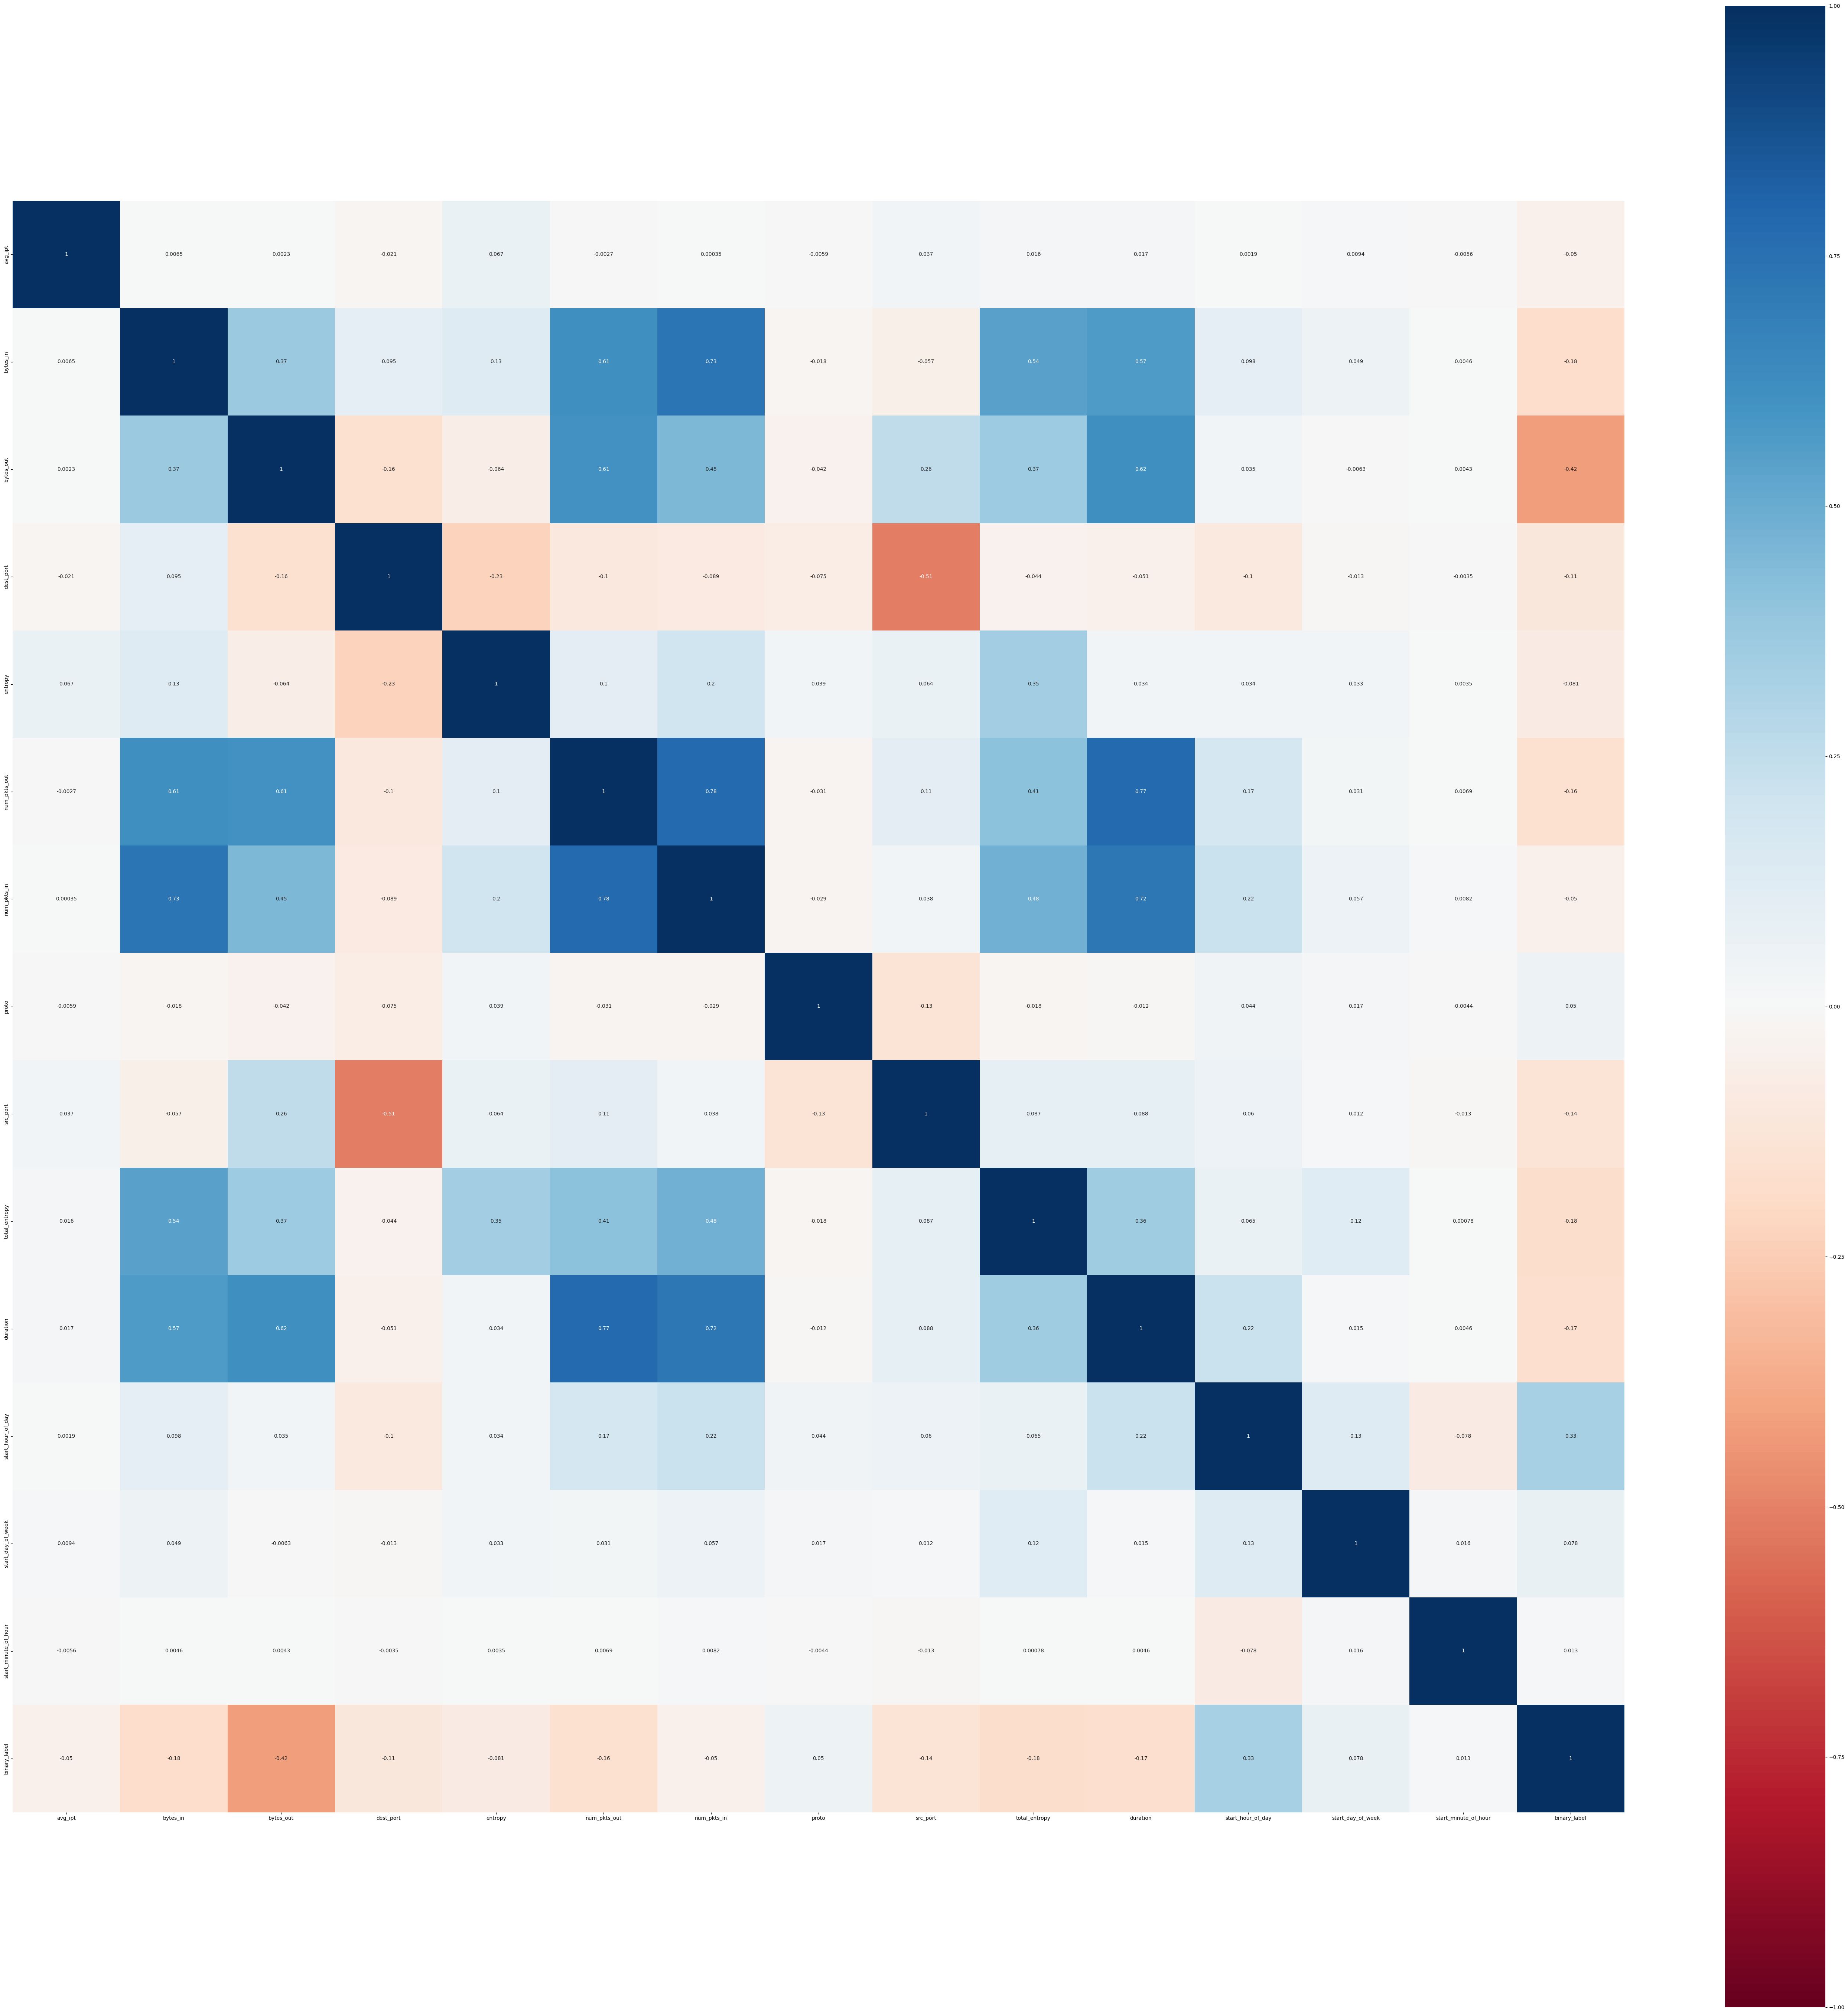

CPU times: user 1.88 s, sys: 98.2 ms, total: 1.98 s
Wall time: 2 s


In [18]:
%%time
# pearson correlation heatmap
plt.figure(figsize=(70, 70))
corr = df_balanced.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='RdBu', vmin=-1, vmax=1, square=True) # annot=True
plt.show()

In [19]:
%%time
correlated_col = set()
is_correlated = [True] * len(corr.columns)
threshold = 0.90
for i in range (len(corr.columns)):
    if(is_correlated[i]):
        for j in range(i):
          if (corr.iloc[i, j] >= threshold) and (is_correlated[j]):
            colname = corr.columns[j]
            is_correlated[j]=False
            correlated_col.add(colname)

print(correlated_col)
print(len(correlated_col))

set()
0
CPU times: user 1.67 ms, sys: 0 ns, total: 1.67 ms
Wall time: 1.67 ms


In [20]:
%%time
df_balanced.drop(correlated_col, axis=1, inplace=True)
print (df_balanced.shape)

(964168, 15)
CPU times: user 14.7 ms, sys: 11.2 ms, total: 25.9 ms
Wall time: 24.8 ms


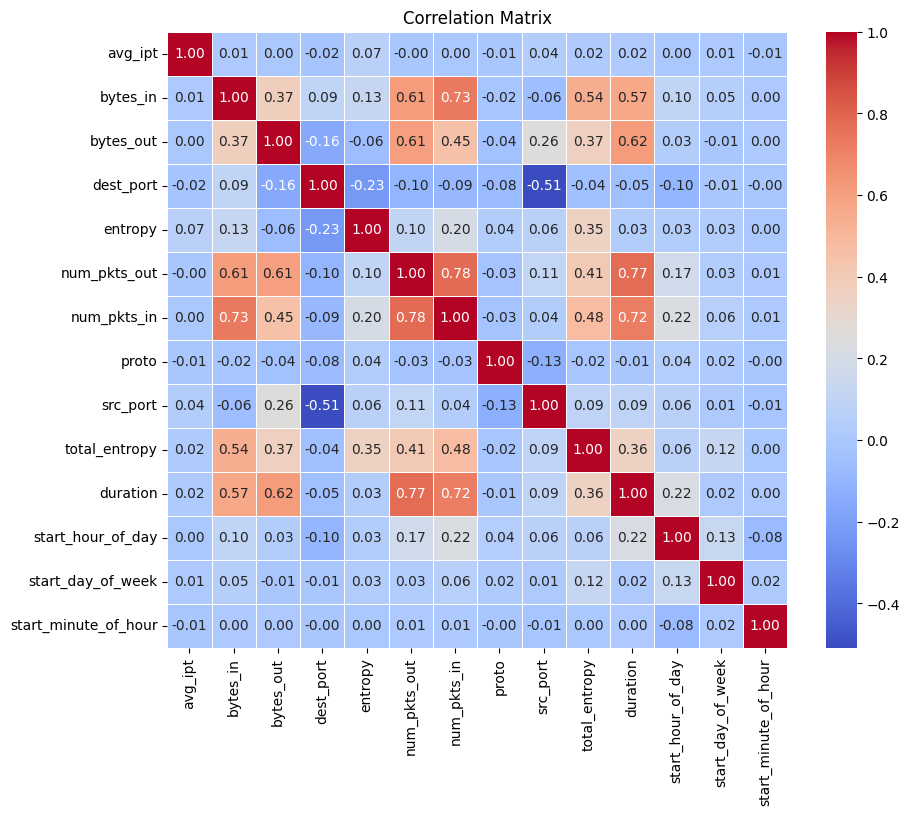

In [21]:
# Calculate correlation matrix
correlation_matrix = df_balanced.drop('binary_label', axis=1).corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

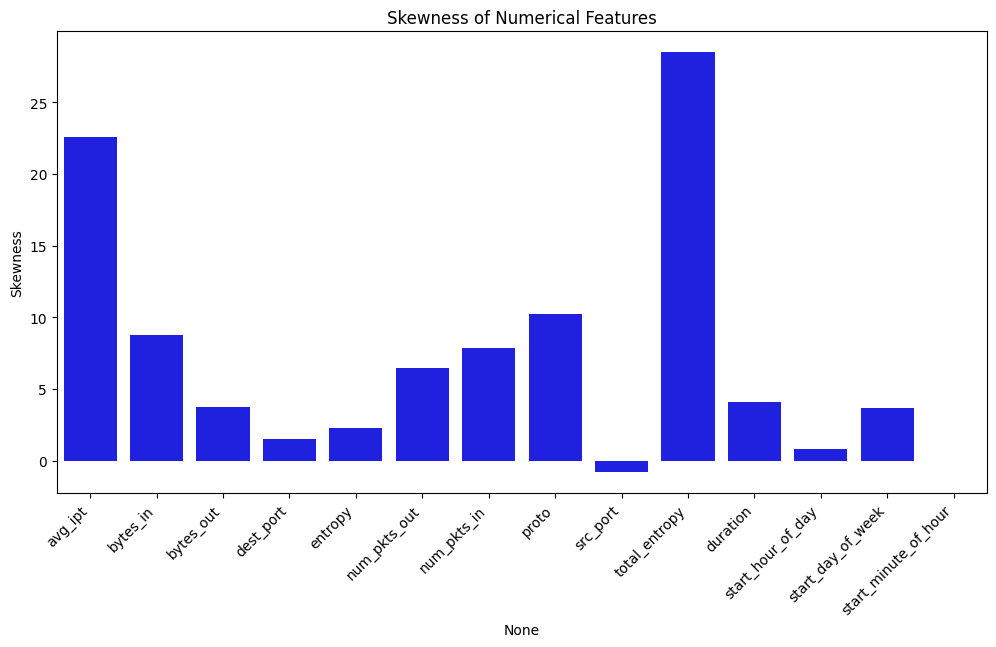

In [22]:
# Calculate skewness for each numerical column
skewness = df_balanced.drop('binary_label', axis=1).skew()

# Create a bar plot or a histogram of skewness values
plt.figure(figsize=(12, 6))
sns.barplot(x=skewness.index, y=skewness.values, color='blue')
plt.xticks(rotation=45, ha='right')
plt.title('Skewness of Numerical Features')
plt.ylabel('Skewness')
plt.show()

In [23]:
%%time
X=df_balanced.drop(["binary_label"], axis=1)
y=df_balanced["binary_label"]

# split the data for evaluation
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state =42, shuffle=True)

CPU times: user 189 ms, sys: 8.64 ms, total: 197 ms
Wall time: 194 ms


In [24]:
x_train

,avg_ipt,bytes_in,bytes_out,dest_port,entropy,num_pkts_out,num_pkts_in,proto,src_port,total_entropy,duration,start_hour_of_day,start_day_of_week,start_minute_of_hour
956978,339.166667,1359,745,22.0,6.913109,15,19,6,37328.0,14545.18100,5.261296,13,1,16
425615,0.000000,0,1751,9200.0,4.994593,2,0,6,45334.0,8745.53200,0.000028,5,0,10
582018,0.000000,0,6891,9200.0,3.347975,5,0,6,47232.0,23070.89800,0.000063,3,1,46
203853,0.000000,0,5792,9200.0,3.891722,5,0,6,45326.0,22540.85500,0.519397,3,0,21
895316,0.000000,0,0,39748.0,0.000000,1,0,6,5900.0,0.00000,0.000000,5,1,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288584,35.857143,34,29,5900.0,5.044661,7,10,6,44376.0,317.81363,0.472773,16,0,57
409916,60.333333,156,256,22.0,7.495762,2,3,6,40106.0,3088.25400,0.181689,14,0,54
147070,35.000000,34,29,5900.0,5.127916,7,10,6,45512.0,323.05870,0.471355,16,0,19
741539,0.000000,0,4312,9200.0,5.612308,3,0,6,47234.0,24200.27100,0.000021,13,5,42


In [25]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training set
x_train = scaler.fit_transform(x_train)

# Transform the testing set using the same scaler
x_test = scaler.transform(x_test)

In [27]:
# --- LightGBM Model ---
print("--- Training LightGBM Model ---")

# Initialize LightGBM classifier
lgb_clf = lgb.LGBMClassifier(random_state=42)

# Train the model
lgb_clf.fit(x_train, y_train)

--- Training LightGBM Model ---


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 357809, number of negative: 413525
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2621
[LightGBM] [Info] Number of data points in the train set: 771334, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.463883 -> initscore=-0.144719
[LightGBM] [Info] Start training from score -0.144719


LGBMClassifier(random_state=42)

In [28]:
# Make predictions (probabilities) on the test set
y_pred_proba_lgb = lgb_clf.predict_proba(x_test)[:, 1]

# Make predictions (binary) on the test set
y_pred_lgb = lgb_clf.predict(x_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


:# **Calculate the Metrics for One Class SVM**

In [29]:
print("--- Logistic Regression ---")
print("Classification Report:")
print(classification_report(y_test, y_pred_lgb))
print("ROC AUC Score:")
print(roc_auc_score(y_test, y_pred_proba_lgb))

--- Logistic Regression ---
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    103684
           1       1.00      1.00      1.00     89150

    accuracy                           1.00    192834
   macro avg       1.00      1.00      1.00    192834
weighted avg       1.00      1.00      1.00    192834

ROC AUC Score:
0.9999972874783715


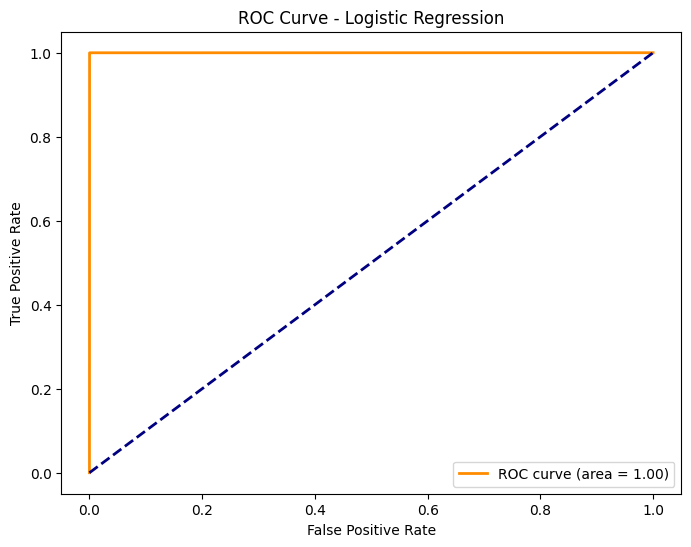

In [30]:
# Plot ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lgb)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_lr:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.show()

In [32]:
# Calculate the confusion matrix
conf_matrix_lgb = confusion_matrix(y_test, y_pred_lgb)

# Print the confusion matrix
print("Confusion Matrix for Logistic Regression:")
print(conf_matrix_lgb)

Confusion Matrix for Logistic Regression:
[[103651     33]
 [    17  89133]]


In [33]:
# Extract TN, FP, FN, TP from the confusion matrix
# The confusion matrix structure for binary classification in sklearn is:
# [[TN, FP],
#  [FN, TP]]
tn, fp, fn, tp = conf_matrix_lgb.ravel()

# Print the values
print("\nConfusion Matrix Components:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")


Confusion Matrix Components:
True Negatives (TN): 103651
False Positives (FP): 33
False Negatives (FN): 17
True Positives (TP): 89133




```
# This is formatted as code
```

**CatBoost**

In [34]:
# Initialize CatBoost classifier
# 'verbose=0' suppresses training output
cat_clf = cb.CatBoostClassifier(iterations=100, # Number of trees
                                 learning_rate=0.1,
                                 loss_function='Logloss', # For binary classification
                                 eval_metric='AUC',
                                 random_state=42,
                                 verbose=0)

In [35]:
# Train the model
cat_clf.fit(x_train, y_train)

In [36]:
# Make predictions (probabilities) on the test set
y_pred_proba_cat = cat_clf.predict_proba(x_test)[:, 1]

In [37]:
# Make predictions (binary) on the test set
y_pred_cat = cat_clf.predict(x_test)

--- CatBoost ---
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    103684
           1       1.00      1.00      1.00     89150

    accuracy                           1.00    192834
   macro avg       1.00      1.00      1.00    192834
weighted avg       1.00      1.00      1.00    192834

ROC AUC Score:
0.9999658240449869


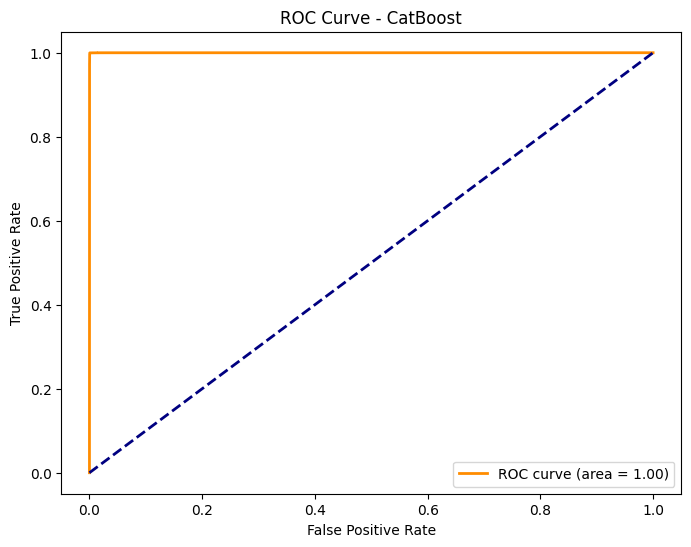

In [38]:
# Evaluate
print("--- CatBoost ---")
print("Classification Report:")
print(classification_report(y_test, y_pred_cat))
print("ROC AUC Score:")
print(roc_auc_score(y_test, y_pred_proba_cat))
# Plot ROC curve
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_proba_cat)
roc_auc_knn = auc(fpr_knn, tpr_knn)
plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_knn:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CatBoost')
plt.legend(loc="lower right")
plt.show()

In [39]:
# Calculate the confusion matrix
conf_matrix_cat = confusion_matrix(y_test, y_pred_cat)

# Print the confusion matrix
print("Confusion Matrix for CatBoost:")
print(conf_matrix_cat)

Confusion Matrix for CatBoost:
[[103610     74]
 [    68  89082]]


In [40]:
# Extract TN, FP, FN, TP from the confusion matrix
# The confusion matrix structure for binary classification in sklearn is:
# [[TN, FP],
#  [FN, TP]]
tn, fp, fn, tp = conf_matrix_cat.ravel()

# Print the values
print("\nConfusion Matrix Components:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")


Confusion Matrix Components:
True Negatives (TN): 103610
False Positives (FP): 74
False Negatives (FN): 68
True Positives (TP): 89082
